Imports and set-up

In [1]:
# makes figures interactable
%matplotlib notebook

# reloads changes to external files without restarting the notebook
%load_ext autoreload
%autoreload 2

#import math and plotting tools
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng()

#import brain area module
from brain import BrainArea

Define parameters of the model and instantiate an input area and two brain areas

In [17]:
n_inputs = 1000
n_neurons = 1000
cap_size = 30
density = 0.3

n_symbols = 2 + 1
symbols = np.zeros((n_symbols, n_inputs))
for i in range(n_symbols):
    symbols[i, i*cap_size : (i+1) * cap_size] = 1.

n_states = 2 + 2
states = np.zeros((n_states, n_neurons))
for i in range(n_states):
    states[i, i*cap_size : (i+1) * cap_size] = 1.

arcs = np.zeros((n_states, n_symbols, n_neurons))
for i in range(n_states):
    for j in range(n_symbols):
        arcs[i, j, (i * n_symbols + j) * cap_size : (i * n_symbols + j + 1) * cap_size] = 1.

state_area = BrainArea(n_neurons, n_neurons, cap_size, density, plasticity=1e3, norm_init=False)
arc_area = BrainArea([n_inputs, n_neurons], n_neurons, cap_size, density, plasticity=1e3, norm_init=False)
arc_area.recurrent_weights = np.zeros_like(arc_area.recurrent_weights)

We will train the network to simulate the following state machine, which recognizes the language consisting of strings containing an even number of zeros.

![image](fsm.png)

Define the transitions of the state machine

In [18]:
transition_list = [[0, 0, 1], [0, 1, 0], [0, 2, 2], [1, 0, 0], [1, 1, 1], [1, 2, 3]]

Train the network by presenting the inputs and output of each transition

In [19]:
state_area.inhibit()
arc_area.inhibit()
for transition in transition_list:
    arc_area.set_input([symbols[transition[1]], states[transition[0]]], input_area=[0, 1])
    arc_area.fire(arcs[transition[0], transition[1]])
    
    state_area.set_input(arc_area.read())
    state_area.fire(states[transition[2]])    
    
    state_area.inhibit()
    arc_area.inhibit()

Test whether the network correctly classifies an arbitrary string

In [32]:
# positive example
sequence = [1, 0, 0, 1, 0, 0, 2] 
# negative example
# sequence = [0, 0, 1, 1, 0, 0, 0, 1, 2]
outputs = np.zeros((len(sequence), n_neurons))

state_area.inhibit()
arc_area.inhibit()
state_area.fire(states[0], update=False)
for j in range(len(sequence)):
    arc_area.set_input([symbols[sequence[j]], state_area.read()], input_area=[0, 1])
    arc_area.step(update=False)

    state_area.set_input(arc_area.read())
    state_area.step(update=False)
    outputs[j] = state_area.read()
state_area.inhibit()
arc_area.inhibit()

<IPython.core.display.Javascript object>


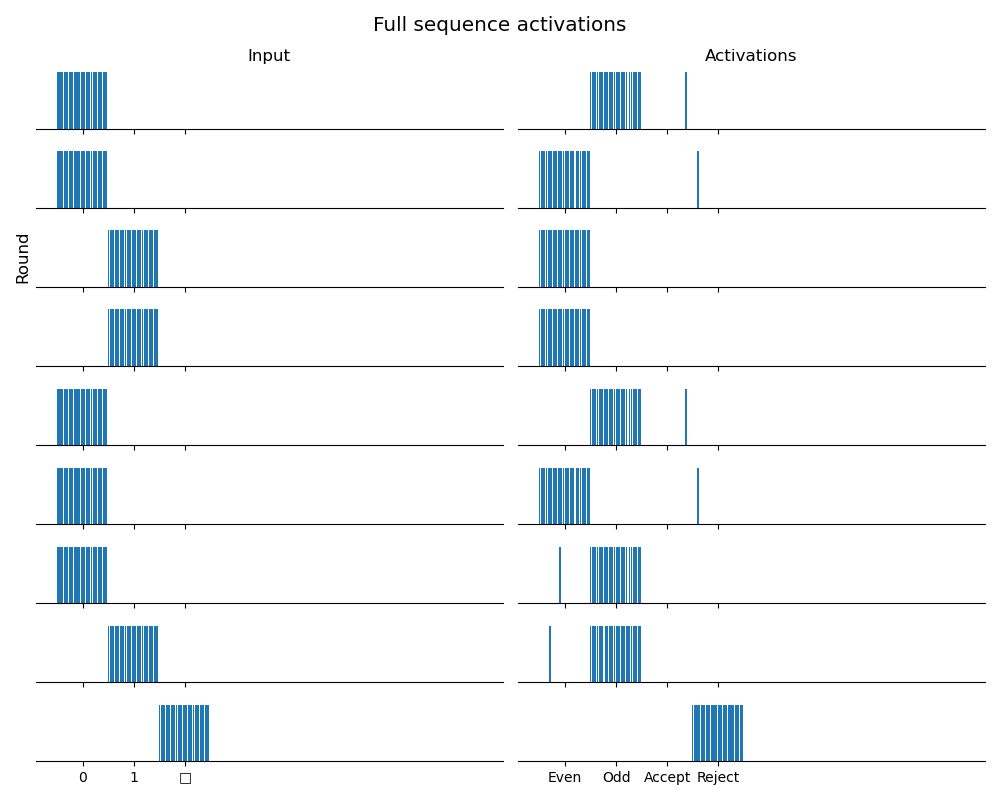

In [34]:
fig, axes = plt.subplots(len(sequence), 2, figsize=(10, 8), sharey=True)
for i in range(len(sequence)):
    axes[i, 0].bar(np.arange(n_inputs // 4), symbols[sequence[i]][:n_inputs // 4])
    axes[i, 1].bar(np.arange(n_neurons // 4), outputs[i][:n_neurons // 4])
axes[0, 0].set_title('Input')
axes[0, 1].set_title('Activations')
axes[2, 0].set_ylabel('Round', fontsize='large')
fig.suptitle('Full sequence activations', fontsize='x-large')

for ax in axes[:, 0]:
    ax.set_xticks([15, 45, 75])
    ax.set_xticklabels([])
    
for ax in axes[:, 1]:
    ax.set_xticks([15, 45, 75, 105])
    ax.set_xticklabels([])

axes[-1, 0].set_xticklabels(['0', '1', '□'])

axes[-1, 1].set_xticklabels(['Even', 'Odd', 'Accept', 'Reject'])

for ax in axes.flatten():
    ax.set_yticks([])
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
fig.tight_layout()